In [1]:
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
load_dotenv()

True

In [3]:
# Model
llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
class ChatState(MessagesState):
    summary: str

In [6]:
def summarize_conversation(state: ChatState):

    existing_summary = state["summary"]

    # Build summarization prompt
    if existing_summary:
        prompt = (
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using the new conversation above."
        )
    else:
        prompt = "Summarize the conversation above."

    messages_for_summary = state["messages"] + [
        HumanMessage(content=prompt)
    ]

    response = llm.invoke(messages_for_summary)

    # Keep only last 2 messages verbatim
    messages_to_delete = state["messages"][:-2]

    return {
        "summary": response.content,
        "messages": [RemoveMessage(id=m.id) for m in messages_to_delete],
    }

In [7]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role": "system",
            "content": f"Conversation summary:\n{state['summary']}"
        })

    messages.extend(state["messages"])

    print(messages)

    response = llm.invoke(messages)
    return {"messages": [response]}

In [8]:
def should_summarize(state: ChatState):
    return len(state["messages"]) > 6

In [9]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)
builder.add_node("summarize", summarize_conversation)

builder.add_edge(START, "chat")

builder.add_conditional_edges(
    "chat",
    should_summarize,
    {
        True: "summarize",
        False: "__end__",
    }
)

builder.add_edge("summarize", "__end__")

In [10]:
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

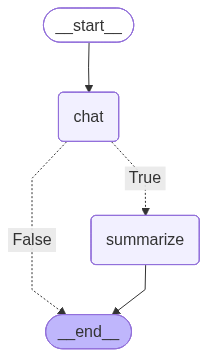

In [12]:
graph

In [13]:
config = {"configurable": {"thread_id": "t1"}}

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [14]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [15]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='734d6f54-96b4-426e-ab2b-0f1d20a412e3')]

--- STATE ---
summary: 
num_messages: 2
messages:
- HumanMessage : Quantum Physics
- AIMessage : Quantum physics, or quantum mechanics, is the branch of physics that deals with 


In [16]:
run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='734d6f54-96b4-426e-ab2b-0f1d20a412e3'), AIMessage(content='Quantum physics, or quantum mechanics, is the branch of physics that deals with the behavior of matter and energy at very small scales, typically at the level of atoms and subatomic particles. It reveals that the classical laws of physics, which govern macroscopic phenomena, do not apply in the quantum realm. Here are some of the key principles and concepts in quantum physics:\n\n1. **Wave-Particle Duality**: Particles, such as electrons and photons, exhibit both particle-like and wave-like behaviors. This is famously illustrated by the double-slit experiment, where particles create an interference pattern indicative of waves when not observed, but behave like particles when measured.\n\n2. **Quantization**: Energy, charge, and other physical properties are quantized, meaning they can only exist in discrete amounts or “quanta.” For example,

In [17]:
run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='734d6f54-96b4-426e-ab2b-0f1d20a412e3'), AIMessage(content='Quantum physics, or quantum mechanics, is the branch of physics that deals with the behavior of matter and energy at very small scales, typically at the level of atoms and subatomic particles. It reveals that the classical laws of physics, which govern macroscopic phenomena, do not apply in the quantum realm. Here are some of the key principles and concepts in quantum physics:\n\n1. **Wave-Particle Duality**: Particles, such as electrons and photons, exhibit both particle-like and wave-like behaviors. This is famously illustrated by the double-slit experiment, where particles create an interference pattern indicative of waves when not observed, but behave like particles when measured.\n\n2. **Quantization**: Energy, charge, and other physical properties are quantized, meaning they can only exist in discrete amounts or “quanta.” For example,

In [18]:
run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='734d6f54-96b4-426e-ab2b-0f1d20a412e3'), AIMessage(content='Quantum physics, or quantum mechanics, is the branch of physics that deals with the behavior of matter and energy at very small scales, typically at the level of atoms and subatomic particles. It reveals that the classical laws of physics, which govern macroscopic phenomena, do not apply in the quantum realm. Here are some of the key principles and concepts in quantum physics:\n\n1. **Wave-Particle Duality**: Particles, such as electrons and photons, exhibit both particle-like and wave-like behaviors. This is famously illustrated by the double-slit experiment, where particles create an interference pattern indicative of waves when not observed, but behave like particles when measured.\n\n2. **Quantization**: Energy, charge, and other physical properties are quantized, meaning they can only exist in discrete amounts or “quanta.” For example,